In [2]:
# Importing libraries for Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

In [3]:
# Importing libraries for ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

In [4]:
# Importing libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random

In [9]:
#reading the data from training and testing directories we have in dataset

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

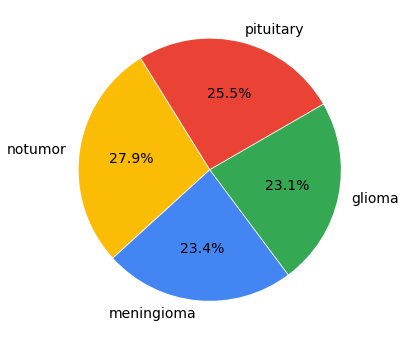

In [12]:
#code to plot the 4 labels (types of tumors) we have in the dataset 

plt.figure(figsize=(14,6))
colors = ['#ea4335', '#fbbc05', '#4285f3', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.005,0.005,0.005,0.005),
        startangle=30);

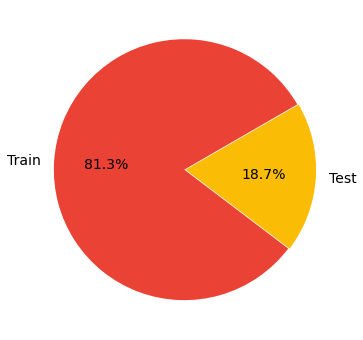

In [16]:
plt.figure(figsize=(14,6))
colors = [ '#ea4335','#fbbc05']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.005,0.005),
        startangle=30);

In [18]:
#function for data augmentation. This includes resizing the images, improving brightness (80%-120%), contrast (80%-120%)
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

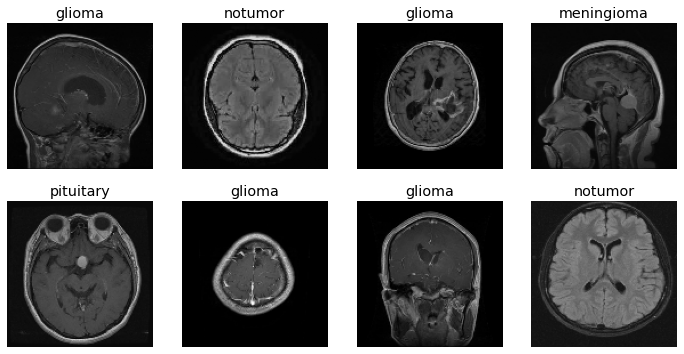

In [20]:
IMAGE_SIZE = 128

#function to display images for reference

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [21]:
#assiging labels we have in the training directory of our dataset
unique_labels = os.listdir(train_dir)

#functions to encode & decode the labels and return the images so that the model can train on the same 
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)


In [22]:
#function takes image paths and the labels. this normalizes, encodes and decodes calling the above functions
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [23]:
#We have used VGG16 model for transfer learning. Froze the top layers by setting the include_top to false and added few other layers to enhance the performance
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(len(unique_labels), activation='softmax'))

2022-12-11 02:22:13.950581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 02:22:13.951573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 02:22:14.136564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 02:22:14.137409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 02:22:14.138188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 0s 0us/step


In [24]:
#to get the summary of the model, displays all the layers with number of parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 32772     
Total params: 14,747,460
Trainable params: 32,772
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
#we have used Adam optimizer with 0.01 learning rate and loss & metrics to compile the model.
#sparse_categorical_crossentropy is a loss function for multi class classification
#sparse_categorical_accuracy to calculate accuracy by dividing the number of accurately predicted images by the total number of images
model.compile(optimizer=Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [34]:
batch_size = 50
steps = int(len(train_paths)/batch_size)
epochs = 50
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/50


2022-12-11 02:26:23.978062: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


114/114 [==============================] - 62s 440ms/step - loss: 1.1430 - sparse_categorical_accuracy: 0.7684
Epoch 2/50
114/114 [==============================] - 24s 200ms/step - loss: 0.4680 - sparse_categorical_accuracy: 0.8668
Epoch 3/50
114/114 [==============================] - 23s 202ms/step - loss: 0.3563 - sparse_categorical_accuracy: 0.8958
Epoch 4/50
114/114 [==============================] - 27s 233ms/step - loss: 0.3425 - sparse_categorical_accuracy: 0.9000
Epoch 5/50
114/114 [==============================] - 23s 203ms/step - loss: 0.4033 - sparse_categorical_accuracy: 0.8961
Epoch 6/50
114/114 [==============================] - 23s 202ms/step - loss: 0.3493 - sparse_categorical_accuracy: 0.9131
Epoch 7/50
114/114 [==============================] - 23s 205ms/step - loss: 0.4279 - sparse_categorical_accuracy: 0.9030
Epoch 8/50
114/114 [==============================] - 23s 203ms/step - loss: 0.2898 - sparse_categorical_accuracy: 0.9281
Epoch 9/50
114/114 [===============

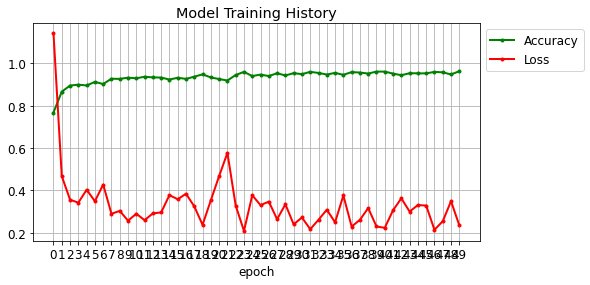

In [36]:
#code to plot graph for accuracy and loss
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [37]:
#decoding the same and appending them to y_pred and y_true
#y_pred is predicted and y_true is ground truth
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

41it [00:19,  2.08it/s]                        


In [38]:
#below is the get the report for predictions and ground truth
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.99      0.85      0.92       300
  meningioma       0.86      0.94      0.90       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.95      0.98      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



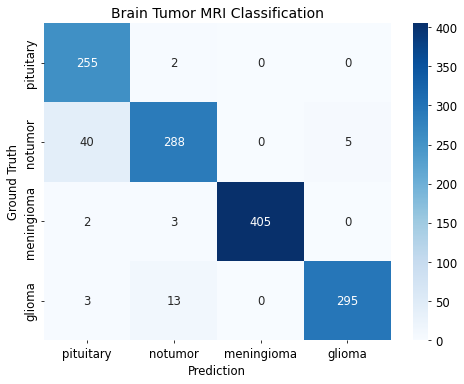

In [39]:
#code to get the confusion matrix (explained in report)

labels=['pituitary','notumor', 'meningioma', 'glioma']
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

cnf = confusion_matrix(y_pred, y_true)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)